In [1]:

# necessary imports
import os
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy

%matplotlib inline

In [2]:
# chek if cuda is set up -> if GPU is available, it works
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# create folder where the trained model can be stored later
path = os.getcwd()
model_path = os.path.join(path, 'Trained_Model')
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [4]:
# set parameters of images such that they fit to ResNet-50 model which will be used for training (224, 224, 3)
img_width, img_height = 224, 224

In [5]:
train_data_dir = '../input/fruits/fruits-360/Training'
test_data_dir =  '../input/fruits/fruits-360/Test'

batch_size = 16

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [7]:
def extract_labels(data_path):
    ''' this function returns a list of labels corresponding to the path provided '''
    return os.listdir(data_path)

def get_label(label_categorical, class_list):
    '''
    this fucntion returns the name of the label corresponding the the provided category 
    
    Inputs:
        1) : label_categorical (numpy array) : categorical array containing only a 1 for the selected label
        2) : class_list (list of strings) : list of strings containing the class names (extracted form the directory)
        
    Outputs:
        returns the string containing the correct class name
    '''
    # get index where label_categorical contains the 1
    index = np.where(label_categorical == 1)[0][0]
    # get label from class list using the index and return it
    return class_list[index]

In [8]:
# print one example image and it's corresponding label from training set
batch_nr = 0
img_nr = np.random.choice(np.arange(0, batch_size))
# get list of class names
class_list = extract_labels(train_data_dir)


Eggplant


Text(0.5, 1.0, 'Eggplant')

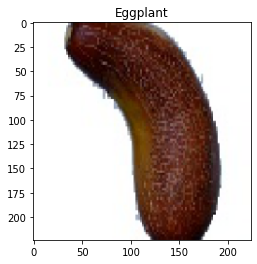

In [9]:
# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
train_batch_tuple = train_generator[batch_nr]
train_batch_data = train_batch_tuple[0]
train_batch_label = train_batch_tuple[1]
test = train_batch_label[img_nr]

# now: get label name
class_name = get_label(train_batch_label[img_nr], class_list)
print(class_name)

# now: plot image and set title to corresponding label
img = train_batch_data[img_nr]
plt.imshow(img)
plt.title(class_name)


## Load and compile pretrained model

In [10]:
# include_top false to not include the last fully connected layer
model_res50 = applications.ResNet50(weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 4s 0us/step


In [11]:
# get netowrk architecture
model_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
# add a global spatial average pooling layer
x = model_res50.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)

# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)

# create the full network so we can train on it
model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [14]:
# get new network architecture
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [16]:
# check locally avaiable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6952979654037913075
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15683598464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1481830869064861232
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [17]:
with tf.device("/device:GPU:0"):
    history_pretrained = model_transfer.fit(
    train_generator,
    epochs=5, shuffle = True, verbose = 1, validation_data = test_generator)

Epoch 1/5
4231/4231 [==============================] - 1533s 360ms/step - loss: 2.1134 - accuracy: 0.6182 - val_loss: 0.1054 - val_accuracy: 0.9788
Epoch 2/5
4231/4231 [==============================] - 979s 231ms/step - loss: 0.1016 - accuracy: 0.9892 - val_loss: 0.0614 - val_accuracy: 0.9861
Epoch 3/5
4231/4231 [==============================] - 972s 230ms/step - loss: 0.0436 - accuracy: 0.9967 - val_loss: 0.0521 - val_accuracy: 0.9869
Epoch 4/5
4231/4231 [==============================] - 979s 231ms/step - loss: 0.0275 - accuracy: 0.9979 - val_loss: 0.0456 - val_accuracy: 0.9877
Epoch 5/5
4231/4231 [==============================] - 959s 227ms/step - loss: 0.0200 - accuracy: 0.9987 - val_loss: 0.0443 - val_accuracy: 0.9874


In [18]:
model_name = 'my_model.h5'
model_path_new = os.path.join(model_path, model_name)

In [19]:
# save full model for later reusage
model_transfer.save(model_path_new)
# load it later using "new_model = tf.keras.models.load_model(model_path_new)""

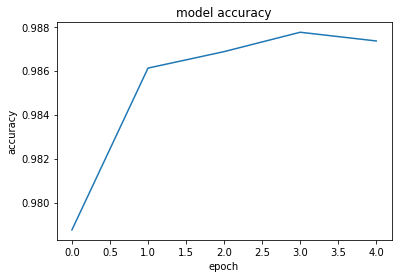

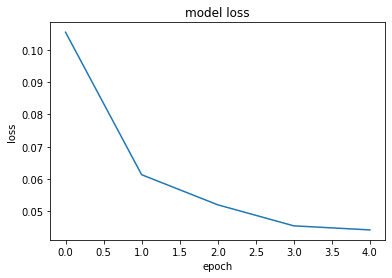

In [20]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# CMAP

In [8]:
# load pre-trained model
model_name = 'my_model.h5'
model_path_new = os.path.join(model_path, model_name)
loaded_model = tf.keras.models.load_model(model_path_new)

OSError: SavedModel file does not exist at: /kaggle/working/Trained_Model/my_model.h5/{saved_model.pbtxt|saved_model.pb}